In [8]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
import datetime

# Generamos datos de entrenamiento para el Teorema de Pitágoras
a_values = np.random.uniform(1, 10, 500)
b_values = np.random.uniform(1, 10, 500)
c_values = np.sqrt(a_values**2 + b_values**2)  # Hipotenusa calculada

X = np.column_stack((a_values, b_values))  # Catetos 'a' y 'b' como entradas
y = c_values  # Hipotenusa 'c' como salida

# Definimos el modelo de red neuronal con más neuronas
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(units=16, activation='relu', name='hidden_layer1'),  # Aumentamos a 16 neuronas
    tf.keras.layers.Dense(units=16, activation='relu', name='hidden_layer2'),  # Aumentamos a 16 neuronas
    tf.keras.layers.Dense(units=8, activation='relu', name='hidden_layer3'),   # Aumentamos a 8 neuronas
    tf.keras.layers.Dense(units=1, name='output_layer')
])

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Configuramos TensorBoard para capturar activaciones en las capas ocultas
log_dir = "logs/pitagoras/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

# Entrenamos el modelo y guardamos el historial de pérdidas
history = model.fit(X, y, epochs=500, verbose=0, callbacks=[tensorboard_callback])

# Guardar el modelo entrenado en formato .keras
model.save('modelo_pitagoras.keras', save_format='keras')
print("Modelo guardado como 'modelo_pitagoras.keras'")


Modelo guardado como 'modelo_pitagoras.keras'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


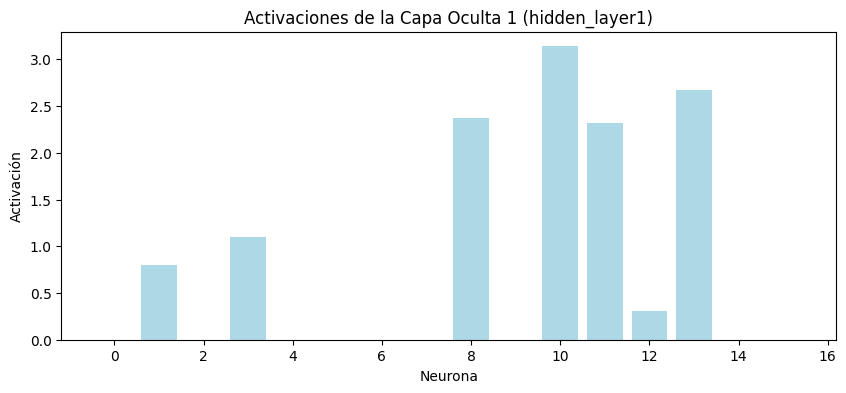

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


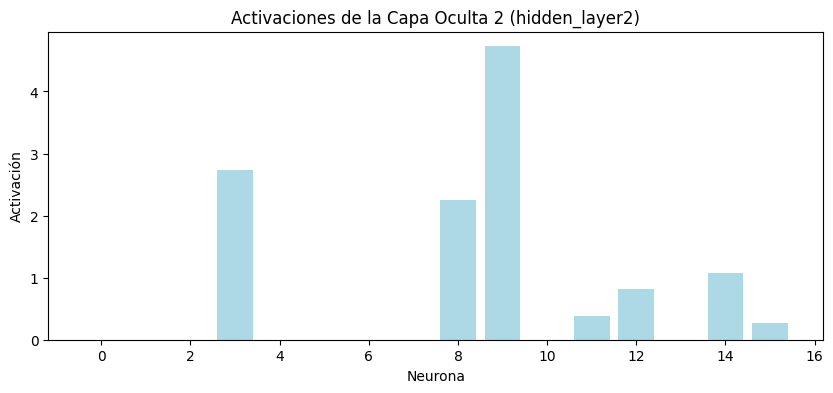

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


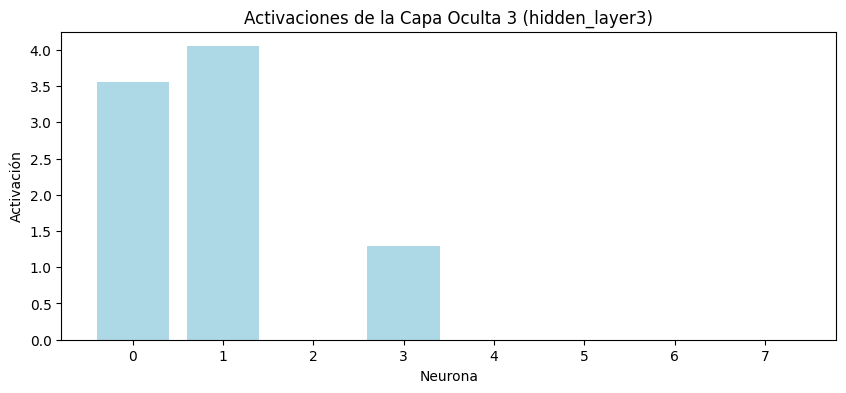

: 

In [13]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input

# Cargar el modelo guardado en formato .keras
model = load_model('modelo_pitagoras.keras')

# Función para obtener activaciones de una capa específica
def get_layer_activation(model, layer, input_data):
    # Crear una nueva entrada explícita para el modelo intermedio
    input_layer = Input(shape=(model.input_shape[-1],))
    x = input_layer
    # Pasar las activaciones hasta la capa deseada
    for lyr in model.layers:
        x = lyr(x)
        if lyr == layer:
            break
    intermediate_layer_model = tf.keras.Model(inputs=input_layer, outputs=x)
    activation = intermediate_layer_model.predict(input_data)
    return activation

# Definir un ejemplo de entrada
input_data = np.array([[3.0, 4.0]])

# Extraer las capas ocultas del modelo
hidden_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Dense) and layer != model.layers[-1]]

# Visualizar las activaciones para cada capa oculta
for i, layer in enumerate(hidden_layers, start=1):
    activation = get_layer_activation(model, layer, input_data)
    plt.figure(figsize=(10, 4))
    plt.bar(range(activation.shape[1]), activation[0], color='lightblue')
    plt.xlabel('Neurona')
    plt.ylabel('Activación')
    plt.title(f'Activaciones de la Capa Oculta {i} ({layer.name})')
    plt.show()


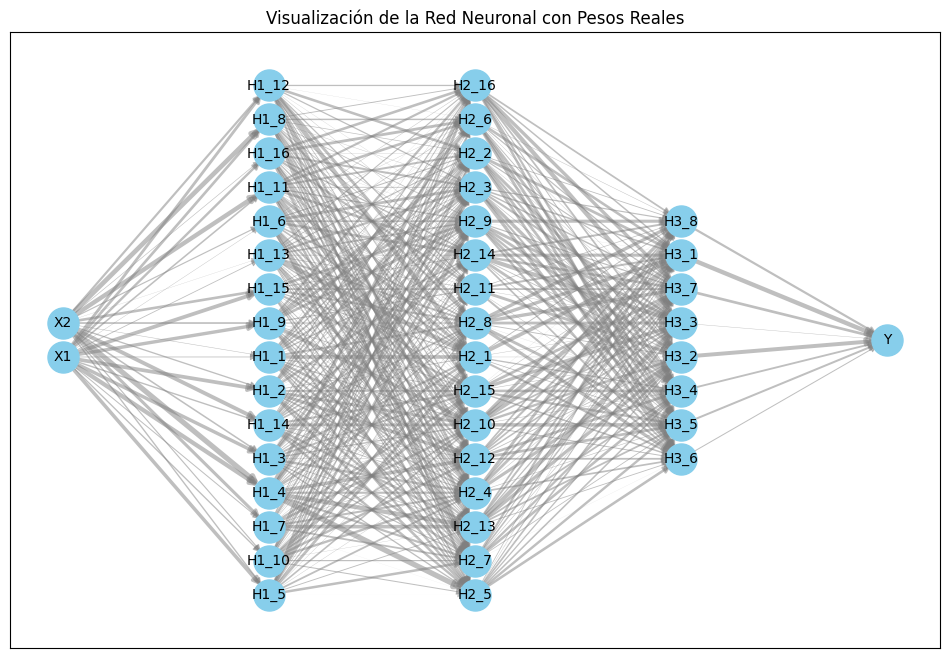

In [10]:
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Ruta del archivo del modelo
model_path = r'C:\xampp_php5\htdocs\php5\py\r\modelo_pitagoras.keras'

# Cargar el modelo
model = tf.keras.models.load_model(model_path)

# Extraer la estructura de la red
num_inputs = model.input_shape[-1]
hidden_layers = [layer.units for layer in model.layers if isinstance(layer, tf.keras.layers.Dense) and 'hidden' in layer.name]
num_outputs = model.output_shape[-1]

# Crear el grafo de la red neuronal
G = nx.DiGraph()

# Añadir nodos para la capa de entrada
for i in range(num_inputs):
    G.add_node(f"X{i+1}", layer=0)

# Añadir nodos para las capas ocultas
for layer_idx, num_neurons in enumerate(hidden_layers):
    for n in range(num_neurons):
        G.add_node(f"H{layer_idx+1}_{n+1}", layer=layer_idx+1)

# Añadir nodo de salida
G.add_node("Y", layer=len(hidden_layers) + 1)

# Añadir conexiones utilizando los pesos del modelo
layer_outputs = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Dense)]
for layer_idx, layer in enumerate(layer_outputs):
    weights, biases = layer.get_weights()
    if layer_idx == 0:
        # Conectar capa de entrada con la primera capa oculta
        for i in range(num_inputs):
            for j in range(hidden_layers[0]):
                weight = weights[i, j]
                G.add_edge(f"X{i+1}", f"H1_{j+1}", weight=weight)
    elif layer_idx < len(hidden_layers):
        # Conectar capas ocultas entre sí
        for i in range(hidden_layers[layer_idx - 1]):
            for j in range(hidden_layers[layer_idx]):
                weight = weights[i, j]
                G.add_edge(f"H{layer_idx}_{i+1}", f"H{layer_idx+1}_{j+1}", weight=weight)
    else:
        # Conectar última capa oculta con la capa de salida
        for i in range(hidden_layers[-1]):
            weight = weights[i, 0]
            G.add_edge(f"H{len(hidden_layers)}_{i+1}", "Y", weight=weight)

# Dibujar la red con colores y grosores según los pesos
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(12, 8))

# Dibujar nodos y etiquetas
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Dibujar conexiones con grosores que representan los pesos
edges = G.edges(data=True)
for u, v, d in edges:
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=5 * abs(d['weight']), alpha=0.5, edge_color='gray')

plt.title("Visualización de la Red Neuronal con Pesos Reales")
plt.show()
